# Part I: Word2vec - the Skip-Gram model:
In this notebook we will implement the Skip-Gram model using pytorch and then we will explore this powerfull word representations.

**NOTE:** this notebook requires you to install pytorch. https://anaconda.org/pytorch/pytorch

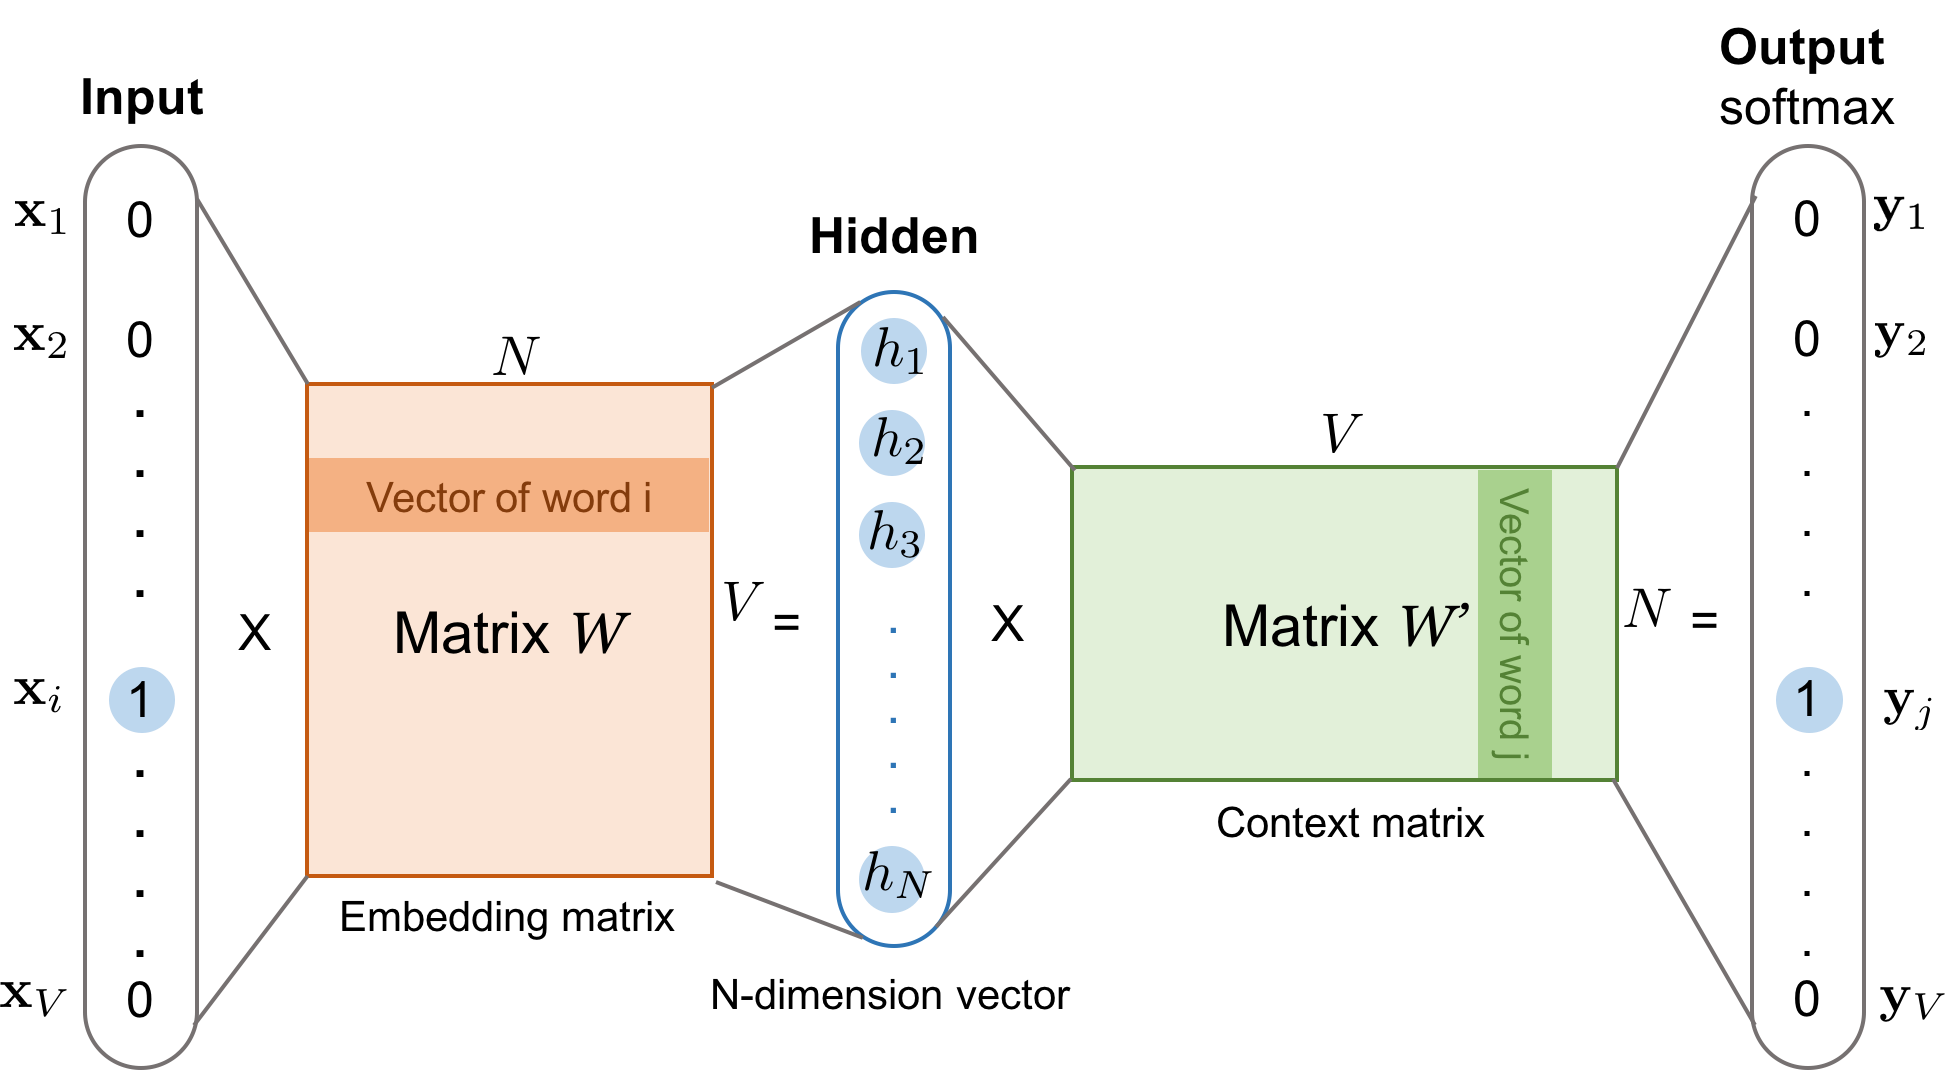

In [1]:
! pip install --user torch

Lets start with a simple corpus:

In [2]:
corpus = [
    'he is a king',
    'she is a queen',
    'she is mad',
    'she is in love',
    'a mountain falls',
    'paris is france capital',   
]

In [3]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [4]:
tokenized_corpus = tokenize_corpus(corpus)
vocabulary = {word for doc in tokenized_corpus for word in doc}
word2idx = {w:idx for (idx, w) in enumerate(vocabulary)}

In [5]:
word2idx

{'a': 1,
 'capital': 5,
 'falls': 4,
 'france': 10,
 'he': 3,
 'in': 2,
 'is': 11,
 'king': 12,
 'love': 9,
 'mad': 8,
 'mountain': 7,
 'paris': 0,
 'queen': 6,
 'she': 13}

Has we have seen in the theoretical lesson we want to build pairs of words that appear inside the same context.
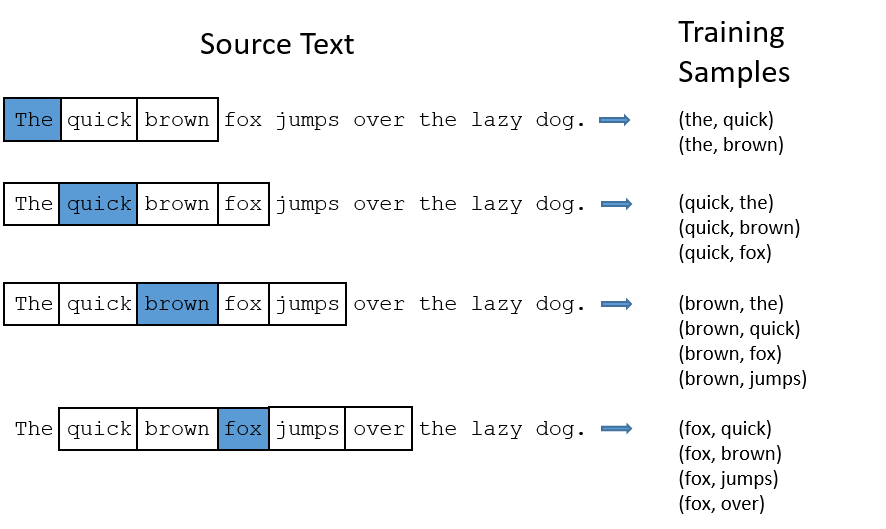

In [6]:
import numpy as np
def build_training(tokenized_corpus, word2idx, window_size=2):
    window_size = 2
    idx_pairs = []
    
    # for each sentence
    for sentence in tokenized_corpus:
        indices = [word2idx[word] for word in sentence]
        # for each word, threated as center word
        for center_word_pos in range(len(indices)):
            # for each window position
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                # make soure not jump out sentence
                if  context_word_pos < 0 or \
                    context_word_pos >= len(indices) or \
                    center_word_pos == context_word_pos:
                    continue  
                context_word_idx = indices[context_word_pos]
                idx_pairs.append((indices[center_word_pos], context_word_idx))
    return np.array(idx_pairs)

In [7]:
training_pairs = build_training(tokenized_corpus, word2idx)

In [8]:
training_pairs

array([[ 3, 11],
       [ 3,  1],
       [11,  3],
       [11,  1],
       [11, 12],
       [ 1,  3],
       [ 1, 11],
       [ 1, 12],
       [12, 11],
       [12,  1],
       [13, 11],
       [13,  1],
       [11, 13],
       [11,  1],
       [11,  6],
       [ 1, 13],
       [ 1, 11],
       [ 1,  6],
       [ 6, 11],
       [ 6,  1],
       [13, 11],
       [13,  8],
       [11, 13],
       [11,  8],
       [ 8, 13],
       [ 8, 11],
       [13, 11],
       [13,  2],
       [11, 13],
       [11,  2],
       [11,  9],
       [ 2, 13],
       [ 2, 11],
       [ 2,  9],
       [ 9, 11],
       [ 9,  2],
       [ 1,  7],
       [ 1,  4],
       [ 7,  1],
       [ 7,  4],
       [ 4,  1],
       [ 4,  7],
       [ 0, 11],
       [ 0, 10],
       [11,  0],
       [11, 10],
       [11,  5],
       [10,  0],
       [10, 11],
       [10,  5],
       [ 5, 11],
       [ 5, 10]])

In [9]:
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
import torch.nn.functional as F
import torch

def get_onehot_vector(word_idx, vocabulary):
    x = torch.zeros(len(vocabulary)).float()
    x[word_idx] = 1.0
    return x

def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    torch.manual_seed(3)
    W1 = Variable(torch.randn(embedding_dims, len(vocabulary)).float(), requires_grad=True)
    W2 = Variable(torch.randn(len(vocabulary), embedding_dims).float(), requires_grad=True)
    losses = []
    for epo in tqdm(range(epochs)):
        loss_val = 0
        for input_word, target in training_pairs:
            x = Variable(get_onehot_vector(input_word, vocabulary)).float()
            y_true = Variable(torch.from_numpy(np.array([target])).long())

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(W2, z1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0)
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true)
            loss_val += loss.item()
            
            # compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_()
            W2.grad.data.zero_()
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, W2, losses

In [10]:
W1, W2, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

In [11]:
import matplotlib.pyplot as plt
def plot_loss(loss):
    x_axis = [epoch+1 for epoch in range(len(loss))]
    plt.plot(x_axis, loss, '-g', linewidth=1, label='Train')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

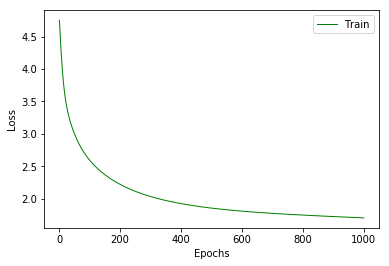

In [12]:
plot_loss(losses)

# Final Embedding Matrix:
From what I have seen the Skip-Gram model can be implemented in 2 different ways:
- With shared parameters, meaning that, W1 and W2 are the same matrix.
- Without shared paramenters accross layers, meaning that, in the end, we have two different matrixes with weights. The final matrix W is the average of both matrixes.

In [13]:
W = W1 + torch.t(W2)
W = (torch.t(W)/2).clone().detach()

In [14]:
W[word2idx["she"]], W[word2idx["mad"]]

(tensor([ 0.6302, -0.1571,  0.3602, -0.1247, -0.2758]),
 tensor([ 0.1772,  0.0729,  0.3073, -0.2823, -0.0833]))

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["falls"]].numpy()])

array([[1.1808747]], dtype=float32)

In [16]:
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["mad"]].numpy()])

array([[0.56817263]], dtype=float32)

As you can see from the previous example the vector representing "she" and the vector representing "mad" are closer then the vector representing "she" and "falls". This happens because "she" and "falls" never appear together inside the same context window...

### Exercise:
Go back to the Skip-Gram function and change it in order to have only 1 matrix of weights instead of 2. Run the training again and comment the results.

<!---
solution:
class Animal():
    def __init__(self, name, age):
        self.name = name
        self.age = age
        self.energy = 0
    
    def eat(self):
        self.energy += 1
        
    def sleep(self):
        self.energy += 3
    
    def play(self):
        self.energy -= 5

class Dog(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("wauf wauf")

class Cat(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("miau miau")        
-->

In [17]:
def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    torch.manual_seed(3)
    W1 = Variable(torch.randn(embedding_dims, len(vocabulary)).float(), requires_grad=True)
    losses = []
    for epo in tqdm(range(epochs)):
        loss_val = 0
        for input_word, target in training_pairs:
            x = Variable(get_onehot_vector(input_word, vocabulary)).float()
            y_true = Variable(torch.from_numpy(np.array([target])).long())

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(torch.transpose(W1, 0, 1), z1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0)
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true)
            loss_val += loss.item()
            
            # compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_()
            W2.grad.data.zero_()
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, losses

In [18]:
W1, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

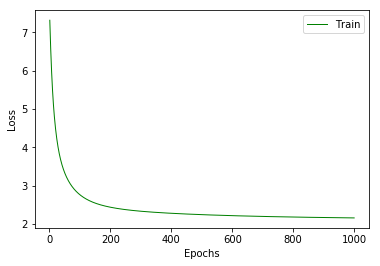

In [19]:
plot_loss(losses)

# Word Embeddings Visualization

Go to https://projector.tensorflow.org/ and visualize Word2Vec embeddings. 

Original Word2Vec repository: https://code.google.com/archive/p/word2vec/

# Part II: Exploring Word Vectors with GloVe:

As we have seen, the word2vec algorithms (such as Skip-Gram) predicts words in a context (e.g. what is the most likely word to appear in "the cat ? the mouse"), while GloVe vectors are based on global counts across the corpus — [see How is GloVe different from word2vec?](https://www.quora.com/How-is-GloVe-different-from-word2vec) on Quora for some better explanations.

In my opinion the best feature of GloVe is that multiple sets of pre-trained vectors are easily available for [download](https://nlp.stanford.edu/projects/glove/), so that's what we'll use here.

Part II of this notebook is taken from [practical-pytorch tutorials](https://github.com/spro/practical-pytorch/blob/master/glove-word-vectors/glove-word-vectors.ipynb)

## Installing torchtext

In [20]:
! pip install --user torchtext

## Loading word vectors
Torchtext includes functions to download GloVe (and other) embeddings

In [21]:
import torch
import torchtext.vocab as vocab

In [22]:
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


Loaded 400000 words
The returned GloVe object includes attributes:

- stoi string-to-index returns a dictionary of words to indexes
- itos index-to-string returns an array of words by index
- vectors returns the actual vectors. To get a word vector get the index to get the vector:

In [23]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

## Finding closest vectors

Going from word → vector is easy enough, but to go from vector → word takes more work. Here I'm (naively) calculating the distance for each word in the vocabulary, and sorting based on that distance:

Anyone with a suggestion for optimizing this, please let me know!

In [24]:
from tqdm import tqdm_notebook as tqdm
def closest(vec, n=10):
    """
    Find the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in tqdm(glove.itos)]
    return sorted(all_dists, key=lambda t: t[1])[:n]

This will return a list of (word, distance) tuple pairs. Here's a helper function to print that list:

In [25]:
def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

Now using a known word vector we can see which other vectors are closest:

In [26]:
print_tuples(closest(get_word('google')))


(0.0000) google
(2.3412) yahoo
(2.8021) aol
(3.1196) microsoft
(3.1771) facebook
(3.2440) web
(3.2447) ebay
(3.3700) netscape
(3.4071) internet
(3.4756) msn


# Word analogies with vector arithmetic
The most interesting feature of a well-trained word vector space is that certain semantic relationships (beyond just close-ness of words) can be captured with regular vector arithmetic.

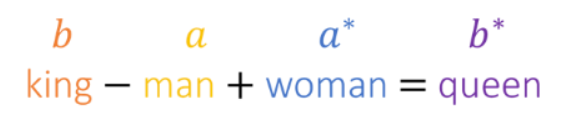

(image borrowed from a slide from [a slide from Omer Levy and Yoav Goldberg](https://levyomer.wordpress.com/2014/04/25/linguistic-regularities-in-sparse-and-explicit-word-representations/))

In [27]:
# In the form w1 : w2 :: w3 : ?
def analogy(w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
   
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word(w2) - get_word(w1) + get_word(w3))
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

In [28]:
analogy('king', 'man', 'queen')


[king : man :: queen : ?]



(2.8391) woman
(3.3545) girl
(3.9518) boy
(4.0233) her
(4.0554) herself


Now let's explore the word space and see what stereotypes we can uncover:

In [ ]:
analogy('man', 'actor', 'woman')
analogy('cat', 'kitten', 'dog')
analogy('dog', 'puppy', 'cat')
analogy('russia', 'moscow', 'france')
analogy('obama', 'president', 'trump')
analogy('rich', 'mansion', 'poor')
analogy('elvis', 'rock', 'eminem')
analogy('paper', 'newspaper', 'screen')
analogy('monet', 'paint', 'michelangelo')
analogy('beer', 'barley', 'wine')
analogy('earth', 'moon', 'sun') # Interesting failure mode
analogy('house', 'roof', 'castle')
analogy('building', 'architect', 'software')
analogy('boston', 'bruins', 'phoenix')
analogy('good', 'heaven', 'bad')
analogy('jordan', 'basketball', 'woods')


[man : actor :: woman : ?]


### The end.